In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
from typing import Tuple

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn

import torch.nn.functional as F
from opacus import PrivacyEngine

In [2]:
DATASETS = '/DATA/Datasets/global_mobility'
apple_name = 'apple_mobility.csv'
google_name = 'google_mobility.csv'

# Read and clean the data with pandas

In [3]:
apple = pd.read_csv(os.path.join(DATASETS, apple_name))
apple_clean = apple[['lat','lng']]
apple_clean.dropna(0,subset=['lat','lng'], inplace = True)
apple_clean.describe()

/tmp/ipykernel_8955/1959420719.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  apple_clean.dropna(0,subset=['lat','lng'], inplace = True)
/tmp/ipykernel_8955/1959420719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_clean.dropna(0,subset=['lat','lng'], inplace = True)


,lat,lng
count,3621.000000,3621.000000
mean,35.907030,-50.992095
std,16.998120,67.981310
min,-45.883330,-159.356788
25%,33.797404,-90.420907
50%,39.005790,-81.469530
75%,43.604440,-3.671814
max,70.000000,178.029127


In [4]:
google = pd.read_csv(os.path.join(DATASETS, google_name))
google_clean = google[['lat','lng']]
google_clean.dropna(0,subset=['lat','lng'], inplace = True)
google_clean.describe()

/tmp/ipykernel_8955/2946920126.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  google = pd.read_csv(os.path.join(DATASETS, google_name))
/tmp/ipykernel_8955/2946920126.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  google_clean.dropna(0,subset=['lat','lng'], inplace = True)
/tmp/ipykernel_8955/2946920126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_clean.dropna(0,subset=['lat','lng'], inplace = True)


,lat,lng
count,350991.000000,350991.000000
mean,35.269006,-57.788262
std,16.907089,58.884663
min,-54.362000,-161.755800
25%,33.098200,-93.203048
50%,38.441896,-82.817604
75%,43.405600,-7.400000
max,70.020652,178.017780


/tmp/ipykernel_8955/1730176736.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = apple_clean.append(google_clean, ignore_index=True)


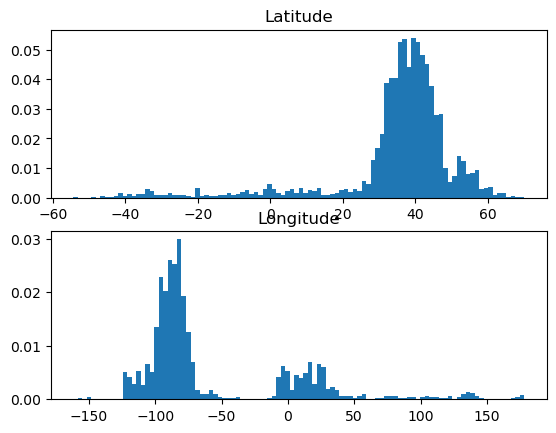

In [5]:
all_data = apple_clean.append(google_clean, ignore_index=True)
fig, (ax1, ax2) = plt.subplots(2)
ax1.hist(all_data['lat'], bins = 100, density = True)
ax1.set_title('Latitude')
ax2.hist(all_data['lng'], bins = 100, density = True)
ax2.set_title('Longitude')
plt.show()

In [6]:
hparams = {
    'batch_size':50,
    'num_epochs':30,
    'in_length':2,
    'latent_dims':2,
    'variational_beta':0.3,
    'learning_rate':1e-3,
    'weight_decay':1e-5,
    'target_epsilon':15
}

# We start creating the network architecture

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:
N, M = int(len(all_data)*0.8)+1, int(len(all_data)*0.2)

training_data, test_data = random_split(torch.Tensor(all_data.to_numpy()),[N, M])

train_dataloader = DataLoader(training_data, batch_size=hparams['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=hparams['batch_size'], shuffle=True)

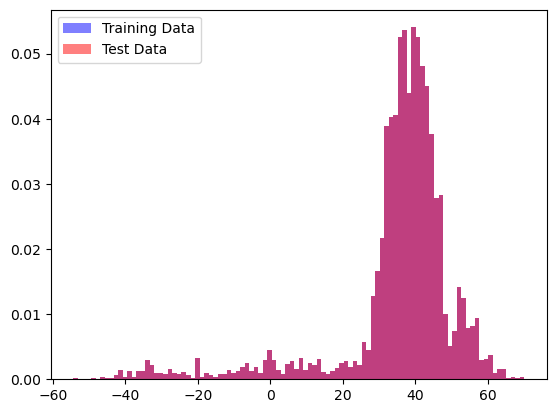

In [9]:
df_tr = pd.DataFrame(training_data.dataset.data.numpy(),columns=['lat','lng'])
df_ts = pd.DataFrame(test_data.dataset.data.numpy(), columns=['lat','lng'])
plt.hist(df_tr['lat'],color='blue', label='Training Data',bins=100,alpha=0.5, density=True)
plt.hist(df_ts['lat'],color='red', label='Test Data',bins=100,alpha=0.5, density=True)
plt.legend()
plt.show()

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_length, latent_dims):        
        super(Encoder, self).__init__()

        self.input_length = input_length
        self.latent_dims = latent_dims
        
        self.linear1 = nn.Linear(self.input_length, 200)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(200, 100)
        self.fc_mu = nn.Linear(in_features=100, out_features=self.latent_dims)
        self.fc_logvar = nn.Linear(in_features=100, out_features=self.latent_dims)

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_length, latent_dims):        
        super(Decoder, self).__init__()

        self.output_length = output_length
        self.latent_dims = latent_dims
        
        self.fc_z = nn.Linear(in_features=self.latent_dims, out_features=100)
        self.linear1 = nn.Linear(100, 200)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(200, self.output_length)
        
        

    def forward(self, z):
        z = self.fc_z(z)
        z = self.activation(self.linear1(z))
        z = self.linear2(z)
        return z

In [12]:
class VAEMobility(nn.Module):
    def __init__(
            self,
            z_dims: int,
            n_in: int,
            ) -> None:
        
        super(VAEMobility, self).__init__()
        self.encoder = Encoder(input_length=n_in,latent_dims=z_dims)
        self.decoder = Decoder(output_length=n_in, latent_dims=z_dims)
    
    def reparametrize(
            self,
            mu:torch.Tensor,
            logvar:torch.Tensor,
            ) -> torch.Tensor:
        # Given mean and logvar returns z
        # reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
        # mu, logvar: mean and log of variance of Q(z|X)
        
        # The factor 1/2 in the exponent ensures that the distribution has unit variance
        std = torch.exp(0.5 * logvar)
        # Random sample
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x: torch.Tensor) -> Tuple[
            torch.Tensor, torch.Tensor, torch.Tensor]:

        latent_mu, latent_logvar = self.encoder(x)
        z = self.reparametrize(latent_mu, latent_logvar)
        x_recon = self.decoder(z)

        return x_recon, latent_mu, latent_logvar

Loss definition

In [13]:
def vae_loss(
        recon_x: torch.Tensor,
        x: torch.Tensor,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        variational_beta: int=1,
        ) -> float:
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the binary cross-entropy.
    
    recon_loss = F.mse_loss(recon_x, x)
    kldivergence = variational_beta * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    mean_batch_loss = (recon_loss +  kldivergence)/x.shape[0]
 
    return mean_batch_loss

In [14]:
def train_batch(
        data_batch: torch.Tensor,
        vae: torch.nn.Module,
        vae_loss: torch.nn.Module,
        optimizer: torch.optim,
        ) -> float:

    data_batch = data_batch.to(device)

    # Get vae reconstruction and loss
    data_batch_recon, latent_mu, latent_logvar = vae(data_batch)
    loss = vae_loss(data_batch_recon, data_batch, latent_mu, latent_logvar, variational_beta = hparams['variational_beta'])

    # backpropagation
    optimizer.zero_grad()
    loss.backward()

    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    
    return loss.item()

# Start Training

In [15]:
import time
start_time=time.time()

privacy_engine = PrivacyEngine()

# Instantiate optimizer and model here
vae = VAEMobility(hparams['latent_dims'],hparams['in_length'])
vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(),lr=hparams['learning_rate'],weight_decay=hparams['weight_decay'])

vae, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=vae,
    optimizer=optimizer,
    data_loader=train_dataloader,
    max_grad_norm=1.0,
    target_epsilon=hparams['target_epsilon'],
    target_delta=1e-5,
    epochs = hparams['num_epochs']
)
vae.to(device)

# This is the number of parameters used in the model
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(hparams['num_epochs']):
    train_loss_avg.append(0)
    num_batches = 0
    
    for i,(data_batch) in enumerate(train_dataloader):
        loss_batch = train_batch(data_batch, vae, vae_loss, optimizer)
        train_loss_avg[-1] += loss_batch
    
    train_loss_avg[-1] /= i
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, hparams['num_epochs'], train_loss_avg[-1]))

print("--- TOTAL TIME: %s min ---" % (round((time.time() - start_time) / 60, 3)))       

/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Number of parameters: 42006
Training ...


/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/torch/nn/modules/module.py:1107: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


Epoch [1 / 30] average reconstruction error: 7.624217
Epoch [2 / 30] average reconstruction error: 3.015930
Epoch [3 / 30] average reconstruction error: 2.745119
Epoch [4 / 30] average reconstruction error: 2.719128
Epoch [5 / 30] average reconstruction error: 2.801814
Epoch [6 / 30] average reconstruction error: 2.880534
Epoch [7 / 30] average reconstruction error: 2.630340
Epoch [8 / 30] average reconstruction error: 3.689249
Epoch [9 / 30] average reconstruction error: 2.280418
Epoch [10 / 30] average reconstruction error: 2.321606
Epoch [11 / 30] average reconstruction error: 3.936526
Epoch [12 / 30] average reconstruction error: 6.935136
Epoch [13 / 30] average reconstruction error: 2.113717
Epoch [14 / 30] average reconstruction error: 2.083501
Epoch [15 / 30] average reconstruction error: 2.653353
Epoch [16 / 30] average reconstruction error: 2.105886
Epoch [17 / 30] average reconstruction error: 1.978117
Epoch [18 / 30] average reconstruction error: 2.129021
Epoch [19 / 30] ave

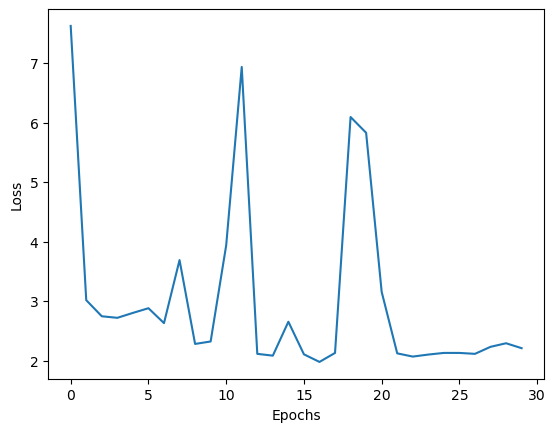

The epsilon is: 23.47 with delta: 1e-09


In [18]:
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
delta = 1e-9
epsilon = privacy_engine.get_epsilon(delta)
print(f'The epsilon is: {epsilon:.2f} with delta: {delta}')

# Evaluation

In [19]:
vae.eval()

test_loss_avg, num_batches = 0, 0
whole_recon = []
for data_batch in test_dataloader:
    
    with torch.no_grad():
        data_batch = data_batch.to(device)

        # vae reconstruction
        data_batch_recon, latent_mu, latent_logvar = vae(data_batch)
        # reconstruction error
        loss = vae_loss(data_batch_recon, data_batch, latent_mu, latent_logvar)
        whole_recon.append(data_batch_recon.cpu().numpy())
        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 3.668657


In [21]:
model_path = f'/DATA/Models/vae_mobility/vae-{epsilon:.2f}-mobility.pt'
torch.save(vae.state_dict(), model_path)

In [22]:
vae_saved = VAEMobility(hparams['latent_dims'],hparams['in_length'])
vae_saved.load_state_dict(torch.load(model_path), strict=False)

_IncompatibleKeys(missing_keys=['encoder.linear1.weight', 'encoder.linear1.bias', 'encoder.linear2.weight', 'encoder.linear2.bias', 'encoder.fc_mu.weight', 'encoder.fc_mu.bias', 'encoder.fc_logvar.weight', 'encoder.fc_logvar.bias', 'decoder.fc_z.weight', 'decoder.fc_z.bias', 'decoder.linear1.weight', 'decoder.linear1.bias', 'decoder.linear2.weight', 'decoder.linear2.bias'], unexpected_keys=['_module.encoder.linear1.weight', '_module.encoder.linear1.bias', '_module.encoder.linear2.weight', '_module.encoder.linear2.bias', '_module.encoder.fc_mu.weight', '_module.encoder.fc_mu.bias', '_module.encoder.fc_logvar.weight', '_module.encoder.fc_logvar.bias', '_module.decoder.fc_z.weight', '_module.decoder.fc_z.bias', '_module.decoder.linear1.weight', '_module.decoder.linear1.bias', '_module.decoder.linear2.weight', '_module.decoder.linear2.bias'])

Generate random samples as test

In [56]:
with torch.no_grad():
    samples = 30000
    # Sample latent vectors from the normal distribution
    # and reconstruct images from the latent vectors
    latent = torch.randn(samples,hparams['latent_dims'],device=device)
    vae.to(device)
    data_recon = vae.decoder(latent)

    synth = pd.DataFrame(data_recon.cpu().numpy(), columns = ['lat','lng'])

In [57]:
def plot_hist(synth, original, column):
    plt.hist(synth[column],bins =1000,label='Sythetic data',alpha =0.5, density=True)
    plt.hist(original[column],bins =1000,label='Original data',alpha=0.5, density=True)
    plt.legend()
    plt.title(column)
    plt.show()

# Before postprocess

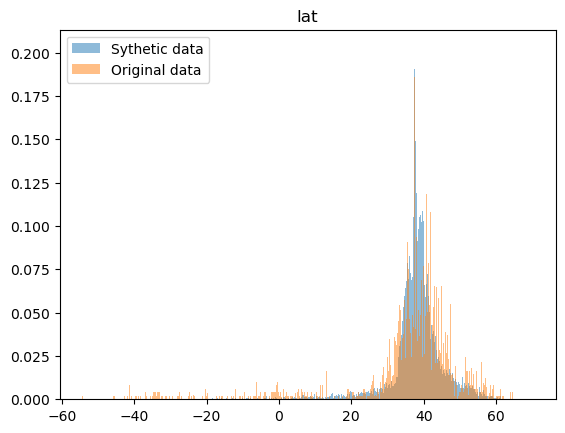

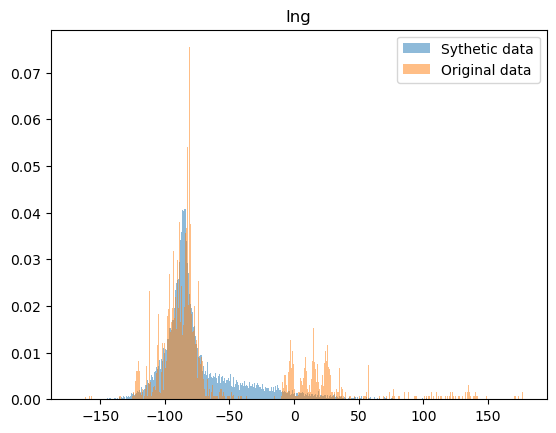

Synthetic data:
                lat           lng
count  30000.000000  30000.000000
mean      38.010452    -73.885872
std        8.041926     31.944111
min      -37.803703   -170.889130
25%       35.858650    -91.266012
50%       38.297039    -83.897564
75%       41.089842    -66.444130
max       70.193649    140.312180
Original data:
                 lat            lng
count  354612.000000  354612.000000
mean       35.275521     -57.718865
std        16.908119      58.988487
min       -54.362000    -161.755800
25%        33.110400     -93.155812
50%        38.449300     -82.739300
75%        43.405600      -7.341670
max        70.020652     178.029127


In [58]:
plot_hist(synth, all_data, 'lat')
plot_hist(synth, all_data, 'lng')
print('Synthetic data:')
print(synth.describe())
print('Original data:')
print(all_data.describe())

# Representing synthetic data

In [59]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

In [60]:
geometry2 = [Point(xy) for xy in zip(all_data['lng'], all_data['lat'])]
geo_df= gpd.GeoDataFrame(all_data,geometry=geometry2)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs('EPSG:900913')

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((20037508.343 -1812498.413, 200..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((3774143.866 -105758.362, 3792946.708..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-964649.018 3205725.605, -964597.245..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-13674486.249 6274861.394, -13..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-13674486.249 6274861.394, -13..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((2096126.508 5765757.958, 2096127.988..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((2234260.104 5249565.284, 2204305.520..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((2292095.761 5139344.949, 2284604.344..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-6866186.192 1204901.071, -6802177.4..."


In [68]:
geometry1 = [Point(xy) for xy in zip(synth['lng'], synth['lat'])]
synth_geo_df = gpd.GeoDataFrame(synth,geometry=geometry1)

# Postprocessing the synthetic data

In [69]:
synth_geo_df = synth_geo_df.assign(**{str(key): synth_geo_df.within(geom) for key, geom in world['geometry'].items()})
synth_geo_df

/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/victor/anaconda3/envs/mobpy/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

,lat,lng,geometry,0,1,2,3,4,5,6,...,167,168,169,170,171,172,173,174,175,176
0,34.878323,-90.874481,POINT (-90.87448 34.87832),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,39.238503,-110.289467,POINT (-110.28947 39.23850),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,39.410694,-90.264191,POINT (-90.26419 39.41069),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,39.408443,-93.472397,POINT (-93.47240 39.40844),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,34.127254,-95.653236,POINT (-95.65324 34.12725),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,30.840815,-71.935646,POINT (-71.93565 30.84081),False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29996,34.953114,-104.442459,POINT (-104.44246 34.95311),False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
29997,-6.592261,-30.946167,POINT (-30.94617 -6.59226),False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29998,54.349884,-36.554573,POINT (-36.55457 54.34988),False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [70]:
countries_cols = synth_geo_df.select_dtypes(include=bool).columns
synth_geo_df['land'] = synth_geo_df[countries_cols].any(axis=1)
synth_geo_df.drop(columns=countries_cols,inplace=True)
synth_geo_df = synth_geo_df[synth_geo_df['land']==True]
synth_geo_df.dropna(inplace=True)
synth_geo_df.drop_duplicates(inplace=True)

/tmp/ipykernel_8955/2585440131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_geo_df.dropna(inplace=True)
/tmp/ipykernel_8955/2585440131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_geo_df.drop_duplicates(inplace=True)


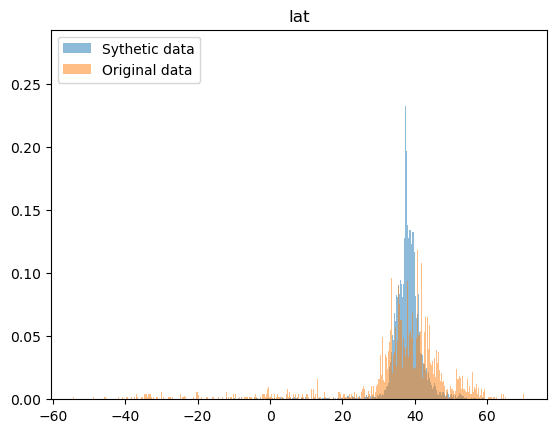

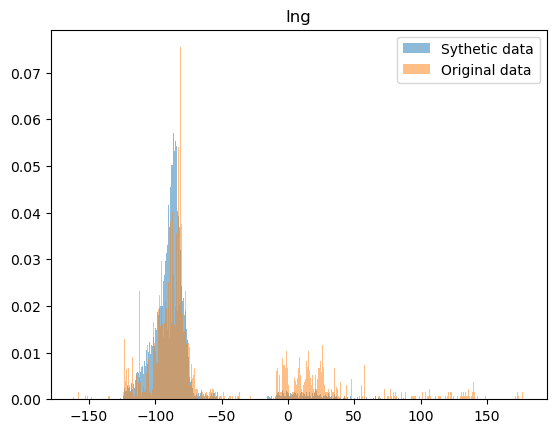

Synthetic data:
                lat           lng
count  30000.000000  30000.000000
mean      38.010452    -73.885872
std        8.041926     31.944111
min      -37.803703   -170.889130
25%       35.858650    -91.266012
50%       38.297039    -83.897564
75%       41.089842    -66.444130
max       70.193649    140.312180
Original data:
                 lat            lng
count  354612.000000  354612.000000
mean       35.275521     -57.718865
std        16.908119      58.988487
min       -54.362000    -161.755800
25%        33.110400     -93.155812
50%        38.449300     -82.739300
75%        43.405600      -7.341670
max        70.020652     178.029127


In [71]:
plot_hist(synth_geo_df, all_data, 'lat')
plot_hist(synth_geo_df, all_data, 'lng')
print('Synthetic data:')
print(synth.describe())
print('Original data:')
print(all_data.describe())

# Real data on the world

<Axes: >

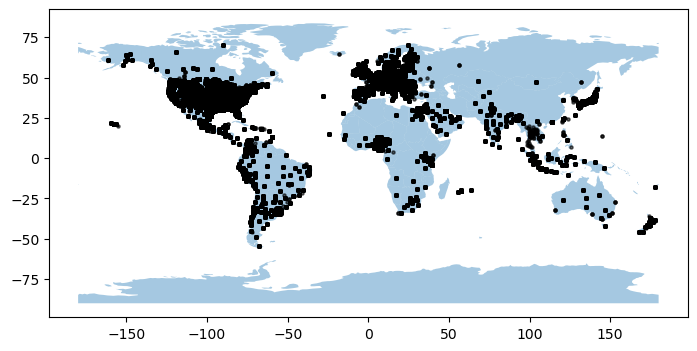

In [72]:
fig, ax = plt.subplots(figsize=(16,4))
world.plot(ax=ax, alpha = 0.4)
geo_df.plot(ax =ax, color='black',marker='o',alpha=0.6, markersize=5)

<Axes: >

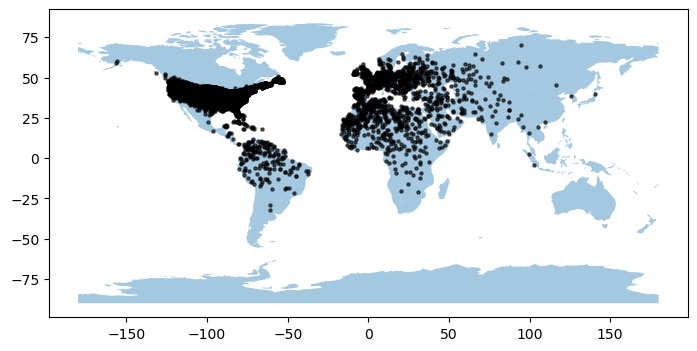

In [73]:
fig, ax = plt.subplots(figsize=(16,4))
world.plot(ax=ax, alpha = 0.4)
synth_geo_df.plot(ax =ax, color='black',marker='o',alpha=0.6, markersize=5)

In [74]:
synth_geo_df[['lat','lng']].to_csv('./synthetic.csv')
all_data.to_csv('./original.csv')